# Imports

In [1]:
# Data
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import optuna
# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import xgboost as xgb
import gpboost as gpb
# DL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Misc
from tqdm import tqdm
from typing import Any, Tuple, Optional, List, Union, Dict # type tips
import warnings
from itertools import combinations
import logging
import os
import pickle

# Data

Note that data has been limited to days 5-81 (inclusive) out of the total 84 days.

- Early days involved learning how to do tasks and getting used to the interface/survey questions (i.e. calibrating responses). 
- Final days sometimes showed odd outliers that perhaps indicate that some subjects stopped responding accurately as they got very close to completion

In [3]:
# Specify path
path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/'

In [30]:
# Raw Data
df_raw = pd.read_csv(path + 'df_raw.csv')

# load undetrended data
df_undetrended = pd.read_csv(path + 'df_cleaned_no_outliers.csv')

# Processed (detrended) data
df = pd.read_csv(path + 'df_cleaned_no_outliers_detrended.csv')

# MLM results
mlm1_4 = pd.read_csv(path + 'mlm_1-4_feature.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_13861/1765045058.py:2: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(path + 'df_raw.csv')


In [33]:
# Filter for observations over 1000
mlm1_4_filtered = mlm1_4[mlm1_4['n_observations'] > 1000]

# Sort by mean_error and group by n_predictors and data_modality
grouped = mlm1_4_filtered.sort_values('mean_error').groupby(['n_predictors', 'data_modality'])

# Get top 3 for each group
top_3_per_group = grouped.head(3)

# Sort for display
display_df = top_3_per_group.sort_values(['n_predictors', 'data_modality', 'mean_error'])

# Show results
display(display_df)

n_predictors data_modality  mean_error  n_observations  \
852               1       passive   10.758397            1419   
768               1       passive   10.770587            1419   
972               1       passive   10.781799            1419   
98                1            sr   10.151003            1404   
728               1            sr   10.164646            1136   
1121              1            sr   10.167338            1136   
647               1          task   10.427903            1245   
447               1          task   10.431599            1245   
516               1          task   10.432881            1262   
2313              2           all   10.135495            1377   
2262              2           all   10.136164            1374   
2345              2           all   10.149726            1377   
4580              2       passive   10.615308            1413   
4612              2       passive   10.625933            1412   
5335              2       passive   10.726303            1419   
2315              2    passive_sr   10.135495            1377   
2263              2    passive_sr   10.136164            1374   
2347              2    passive_sr   10.149726            1377   
1923              2   self_report    9.782211            1067   
1934              2   self_report    9.820505            1067   
1939              2   self_report    9.855647            1070   
2052              2          task   10.033743            1080   
2205              2          task   10.117579            1107   
2306              2          task   10.128782            1080   
5281              3       passive   10.831096            1012   
5482              3       passive   10.861115            1012   
5440              3       passive   10.861311            1012   
1933              3   self_report    9.863872            1224   
1959              3   self_report    9.913743            1377   
1952              3   self_report    9.949325            1224   
9397              4           all   10.168146            1094   
9400              4           all   10.187996            1094   
9399              4           all   10.189166            1094   
9784              4       passive   10.730273            1093   
9789              4       passive   10.746597            1093   
9791              4       passive   10.751068            1093   
10057             4    passive_sr   10.168146            1094   
10060             4    passive_sr   10.187996            1094   
10059             4    passive_sr   10.189166            1094   
10384             4   self_report   10.237106            1067   
10386             4   self_report   10.245529            1067   
10385             4   self_report   10.247966            1055   
10844             4          task   10.636246            1084   
10847             4          task   10.642997            1084   
10850             4          task   10.653451            1084   

                                               feature_1  \
852                                        task_duration   
768                                      task_start_time   
972                                        task_end_time   
98                          sr_DAILY_past24_mentalEffort   
728               sr_DAILY_past24_leisureNonSoloPhysical   
1121                sr_DAILY_past24_leisureNonSoloMental   
647                                       task_nback_MCC   
447                                 task_nback_precision   
516                                    task_nback_rndNum   
2313                         sr_DAILY_past24_leisureSolo   
2262          passive_hk_activity_distanceWalkingRunning   
2345                         sr_DAILY_past24_leisureSolo   
4580          passive_hk_activity_distanceWalkingRunning   
4612                           passive_hk_activity_steps   
5335   fe_rollingMean_3_passive_hk_activity_distanceW...   
2315                         sr_DAILY_past24_leisureSolo

## Data Subsets

### Passive Features

In [ ]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# Additional cols
additional_passive_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'survey_complete',
    'tasks_complete',
    'watch_wearing'
]

# Create df_passive
passive_cols = passive_cols + additional_passive_cols

### Self Report Features

In [ ]:
# create list of self report features
sr_cols = [col for col in df.columns if 'sr_' in col]

# remove affect self report features
sr_cols = [col for col in sr_cols if 'affect' not in col]

# remove social support features
sr_cols = [col for col in sr_cols if 'ss_' not in col]

# remove goal related features
sr_cols = [col for col in sr_cols if '_goal' not in col]

# List of self report features directly related to gap
gap_related_sr = [
    'sr_DAILY_past24_procrastination',
    'sr_DAILY_past24_productivity',
    'sr_DAILY_past24_punctuality',
    'sr_DAILY_past24_satisfaction',
    'sr_DAILY_past24_values',
    'sr_DAILY_past24_gapCause_internal',
    'sr_DAILY_past24_gapCause_external',
    'sr_DAILY_past24_gap',
    'sr_DAILY_past24_ideal',
    'sr_DAILY_past24_change',
    'sr_gap_heuristic',
    'sr_gap_heuristic_intercept',
    'sr_gap_heuristic_slope',
    'sr_DAILY_past48to24_gap',
    'sr_DAILY_past48to24_gapCause_internal',
    'sr_DAILY_past48to24_gapCause_external'
]

# remove self report that seem directly related to gap
sr_cols = [col for col in sr_cols if not any(gap_term in col for gap_term in gap_related_sr)]

# remove occupation features
sr_cols = [col for col in sr_cols if 'occupation' not in col]

# remove cols that are explicitly gaps
sr_cols = [col for col in sr_cols if '_gap' not in col]

### Task Data

In [ ]:
task_cols = [col for col in df.columns if 'task_' in col]

# Remove columns containing '_model_' as these do not change by day
task_cols = [col for col in task_cols if '_model_' not in col]

# getting kernel error - remove task_hanoi_solved from task_cols
task_cols = [col for col in task_cols if 'task_hanoi_solved' not in col]

### Affect Features


In [ ]:
# Affect features
affect_cols = [col for col in df.columns if 'affect_' in col]
affect_pm_cols = [col for col in df.columns if 'affect_' in col and not col.endswith('_am')]

# Helper Functions

In [7]:
def create_train_test_split(data: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Creates train/test splits for time series data on a per-participant basis.
    
    For each participant (PID):
    1. Finds their last day of data collection based on target variable
    2. Removes any data after their last valid day
    3. Creates an 80/20 chronological train/test split
    
    Args:
        data: DataFrame containing participant data with columns:
            - PID: Participant ID
            - day: Day number of study
            - target: Target variable to determine last valid day
        target: Name of target variable column
            
    Returns:
        tuple containing:
            - train_data: DataFrame with first 80% of each participant's data
            - test_data: DataFrame with last 20% of each participant's data
    """
    # Get last day of data collection for each PID based on target variable
    last_days = data.groupby('PID').agg({
        'day': lambda x: x[data[target].notna()].max()
    }).reset_index()

    # Remove any data after each PID's last day
    tt_filtered = pd.merge(
        data,
        last_days,
        on='PID',
        suffixes=('', '_last')
    )
    tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]
    
    # Create train/test splits for each PID
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for pid in tt_filtered['PID'].unique():
        pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
        
        # Sort by day to ensure chronological split
        pid_data = pid_data.sort_values('day')
        
        # Calculate split point at 80%
        split_idx = int(len(pid_data) * 0.8)
        
        # Split the data
        train_pid = pid_data.iloc[:split_idx]
        test_pid = pid_data.iloc[split_idx:]
        
        # Append to main dataframes
        train_data = pd.concat([train_data, train_pid])
        test_data = pd.concat([test_data, test_pid])
        
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [10]:
def plot_model_diagnostics(actual_vals: np.ndarray, predicted_vals: np.ndarray, test_data_clean: pd.DataFrame) -> None:
    """
    Create diagnostic plots for model evaluation.
    
    Parameters
    ----------
    actual_vals : array-like
        The actual target values from the test set
    predicted_vals : array-like 
        The model's predictions for the test set
    test_data_clean : pd.DataFrame
        The cleaned test dataset containing PID column for coloring points
        
    Returns
    -------
    None
        Displays two plots:
        1. Distribution of prediction errors
        2. Actual vs predicted values scatter plot colored by participant
    """
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = actual_vals - predicted_vals
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=actual_vals, y=predicted_vals, ax=ax2, alpha=0.5, 
                    hue=test_data_clean['PID'], palette='viridis', legend=False)
    ax2.plot([actual_vals.min(), actual_vals.max()],
                [actual_vals.min(), actual_vals.max()],
                'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

# Models

## Baseline Models

For continuous predictions we will create our baseline model using the same subjects as used in the predictive model (given that this can differ based on how many subjects have a given data feature).

The baseline model will simply be the target median (within-subject) of the training data, used to predict all values in the test data.

If the collected features have meaningful signal, we would expect the model to perform better than the baseline model.

**Baseline Model for All Data**

Note that the values can change if there is a sub-selection of subjects for different models

In [8]:
target = 'target_wbw_gap_detrended'

Baseline Model Performance Metrics:
MAE: 9.4946
RMSE: 12.9919
Mean error: 11.2432
R²: 0.4853

Data sizes:
Training samples: 5925
Test samples: 1449
Number of subjects in training: 104
Number of subjects in test: 104


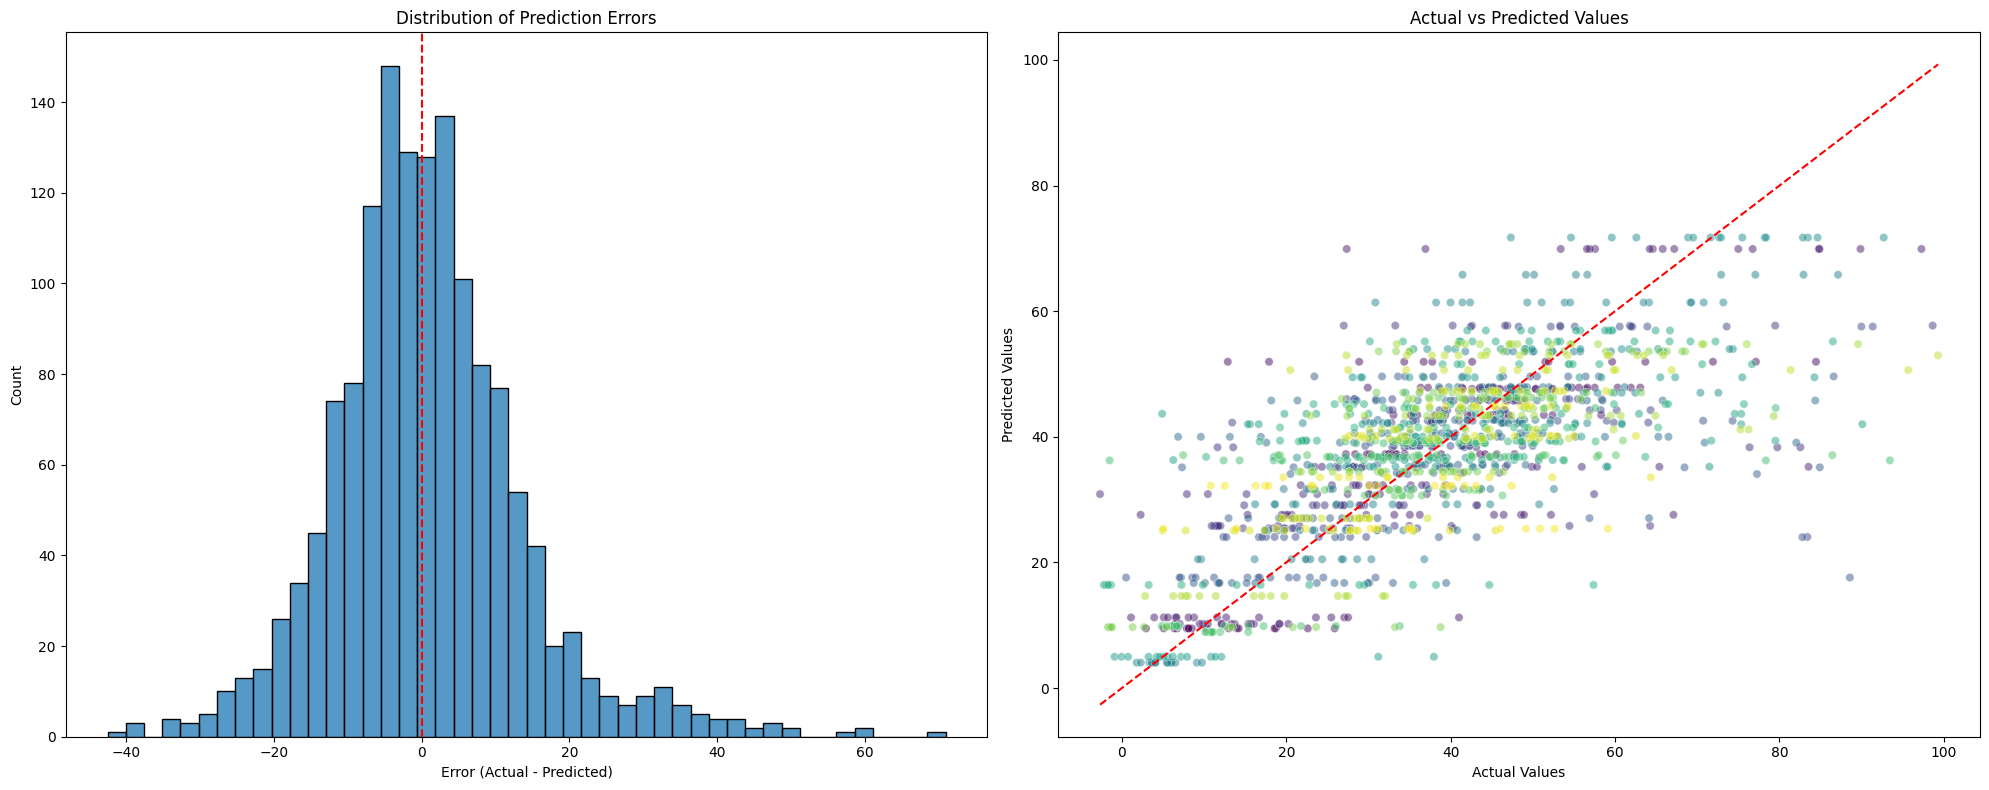

In [11]:
train_data, test_data = train_data, test_data = create_train_test_split(df, target='target_wbw_gap_detrended')

# Drop NAs since not used for calculation
train_data_clean = train_data[[target, 'PID']].dropna()
test_data_clean = test_data[[target, 'PID']].dropna()

# Calculate median target value per subject from training data
train_medians = train_data_clean.groupby('PID')[target].median()

# Initialize predictions array
predictions = np.zeros(len(test_data_clean))

# Make predictions using each subject's median
for pid in test_data_clean['PID'].unique():
    # Get subject's data indices
    mask = test_data_clean['PID'] == pid
    
    # Use subject's training median if available, otherwise use overall median
    if pid in train_medians.index:
        subject_median = train_medians[pid]
    else:
        subject_median = train_data_clean[target].median()
        
    # Fill predictions for this subject
    predictions[mask] = subject_median

# Calculate metrics
mae = mean_absolute_error(test_data_clean[target], predictions)
rmse = np.sqrt(mean_squared_error(test_data_clean[target], predictions))
r2 = r2_score(test_data_clean[target], predictions)
mean_error = (mae + rmse)/2

# Print metrics
print(f"Baseline Model Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f'Mean error: {mean_error:.4f}')
print(f"R²: {r2:.4f}")

# Print data sizes
print(f"\nData sizes:")
print(f"Training samples: {len(train_data_clean)}")
print(f"Test samples: {len(test_data_clean)}")
print(f"Number of subjects in training: {len(train_data_clean['PID'].unique())}")
print(f"Number of subjects in test: {len(test_data_clean['PID'].unique())}")

# Plot diagnostics
plot_model_diagnostics(test_data_clean[target], predictions, test_data_clean)


## Group Level Models

### MLM Models

### XGBoost

### GPBoost

## Individual Level Models

Given that we are collecting ILD we can also consider fitting models at the individual level.

This allows us to leverage the fact that individual differences mean that predictors with no meaningful group level signal may have important individual level signal.

### Linear Regression

## Ensemble Models

### Individual Linear Regression + Best Group Level Model